In [1]:
import csv
import numpy as np
import cv2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import argparse
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Lambda
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Cropping2D
from keras.regularizers import l2


Using TensorFlow backend.


In [40]:
def read_driving_log(lines, prefix):
    with open(prefix + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            if random.choice([0, 1, 2, 3]) != 0:
                continue
            lines.append(line)
    return lines

def add_img(image, measurement):
    images.append(image)
    measurements.append(measurement)

def load_images_adjust_lrc_flip(lines, prefix):
    for line in lines:
        if line[3] == 'steering':
            continue
        for i, steering_adjustment in zip([0, 1, 2], [0, 0.2, -0.2]):
            source_path = line[i]
            filename = source_path.split('/')[-1]
            current_path = prefix + '/IMG/' + filename
            image = cv2.imread(current_path)
            if image is None:
                print("Something broke")
                print(line)
                print(source_path)
                print(type(image))
                print("len images", len(images))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            measurement = float(line[3]) + steering_adjustment
            add_img(image, measurement)
            if i == 0:
                image_flipped = np.fliplr(image)
                measurement_flipped = -measurement
                add_img(image_flipped, measurement_flipped)
    return lines


In [3]:
def brightness_adjust(image):
    # Change to HSV colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Assumming sunny input generate brightness change, slight brighter and
    # significantly darker
    rand = random.uniform(0.3,1.2)
    hsv[:,:,2] = rand*hsv[:,:,2]
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return new_img


In [4]:
def augment_data(image):
    # 50% of the time augment the image
    if random.choice([0, 1]) == 1:
        return image
    else:
        new_img = brightness_adjust(image)
        return new_img


def augment_base_data(images, measurements):
    for i, image in enumerate(images):
        if i % 4 != 0:
            continue
        new_img = brightness_adjust(image)
        add_img(new_img, measurements[i])
    return images, measurements


In [5]:
prefixlist = ['data']
images = []
measurements = []


In [6]:
for prefix in prefixlist:
    print("processing data set: ", prefix)
    lines = []
    lines = read_driving_log(lines, prefix)
    lines = load_images_adjust_lrc_flip(lines, prefix)


processing data set:  data


In [7]:
images, measurements = augment_base_data(images, measurements)


In [8]:
X_train = np.array(images)
y_train = np.array(measurements)


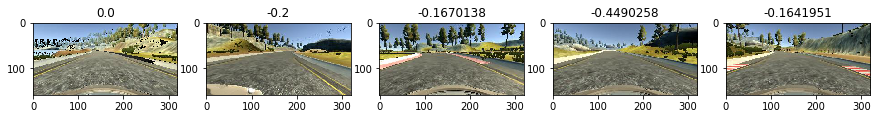

In [9]:
display_n = 5
labels = []
plt.figure(figsize=(15, 15))
for i in range(display_n):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    ax.set_title(measurements[index])
    
plt.show()

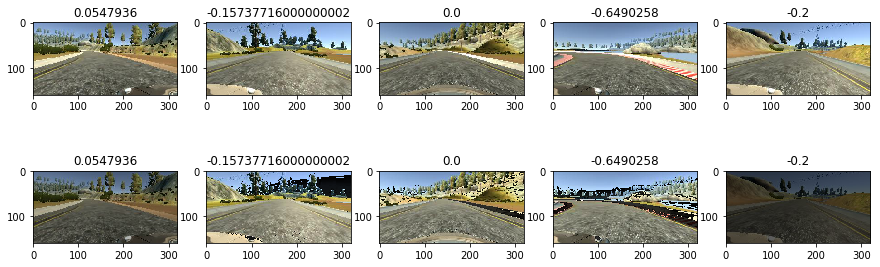

In [10]:
display_n = 5
labels = []
f, axarr = plt.subplots(2, 5, figsize=(15, 5) )
for i in range(display_n):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    axarr[0, i].imshow(image)
    axarr[0, i].set_title(measurements[index])
    augimage = brightness_adjust(image)
    axarr[1, i].imshow(augimage)
    axarr[1, i].set_title(measurements[index])

plt.show()

len tmp_lines 2
[['IMG/center_2016_12_01_13_40_09_859.jpg', ' IMG/left_2016_12_01_13_40_09_859.jpg', ' IMG/right_2016_12_01_13_40_09_859.jpg', ' 0', ' 0', ' 0', ' 6.066793'], ['IMG/center_2016_12_01_13_41_49_114.jpg', ' IMG/left_2016_12_01_13_41_49_114.jpg', ' IMG/right_2016_12_01_13_41_49_114.jpg', ' 0', ' 0.9855326', ' 0', ' 30.18689']]
len tmp_X 8


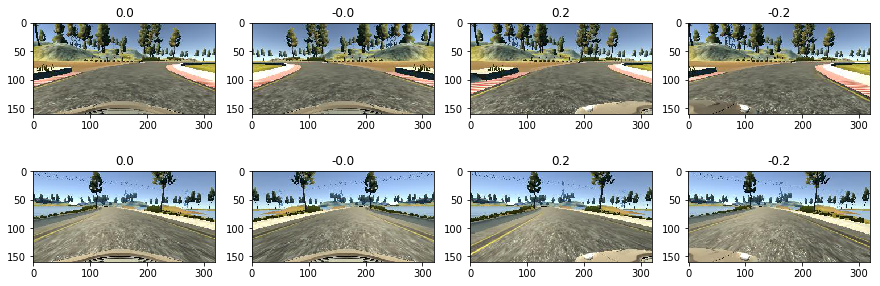

In [11]:
#test left, right, center load and flip

def add_img_tmp(image, measurement):
    tmp_images.append(image)
    tmp_measurements.append(measurement)

def load_images_adjust_lrc_flip(lines, prefix):
    for line in lines:
        if line[3] == 'steering':
            continue
        for i, steering_adjustment in zip([0, 1, 2], [0, 0.2, -0.2]):
            source_path = line[i]
            filename = source_path.split('/')[-1]
            current_path = prefix + '/IMG/' + filename
            image = cv2.imread(current_path)
            if image is None:
                print("Something broke")
                print(line)
                print(source_path)
                print(type(image))
                print("len images", len(images))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            measurement = float(line[3]) + steering_adjustment
            add_img_tmp(image, measurement)
            if i == 0:
                image_flipped = np.fliplr(image)
                measurement_flipped = -measurement
                add_img_tmp(image_flipped, measurement_flipped)
    return lines

tmp_images = []
tmp_measurements = []
tmp_lines = []
tmp_lines.append(lines[random.randint(0, len(lines))])
tmp_lines.append(lines[random.randint(0, len(lines))])

print("len tmp_lines", len(tmp_lines))
print(tmp_lines)

load_images_adjust_lrc_flip(tmp_lines, prefix)
tmp_X_train = np.array(tmp_images)
tmp_y_train = np.array(tmp_measurements)
print("len tmp_X", len(tmp_X_train))


display_n = len(tmp_images)
labels = []
f, axarr = plt.subplots(2, 4, figsize=(15, 5) )

for i in range(display_n):
    image = tmp_X_train[i].squeeze()
    axarr[i//4, i%4].imshow(image)
    axarr[i//4, i%4].set_title(tmp_y_train[i])

    
plt.show()

processing data set:  recoverdata
processing data set:  data
processing data set:  2ndtrack
processing data set:  firstdata


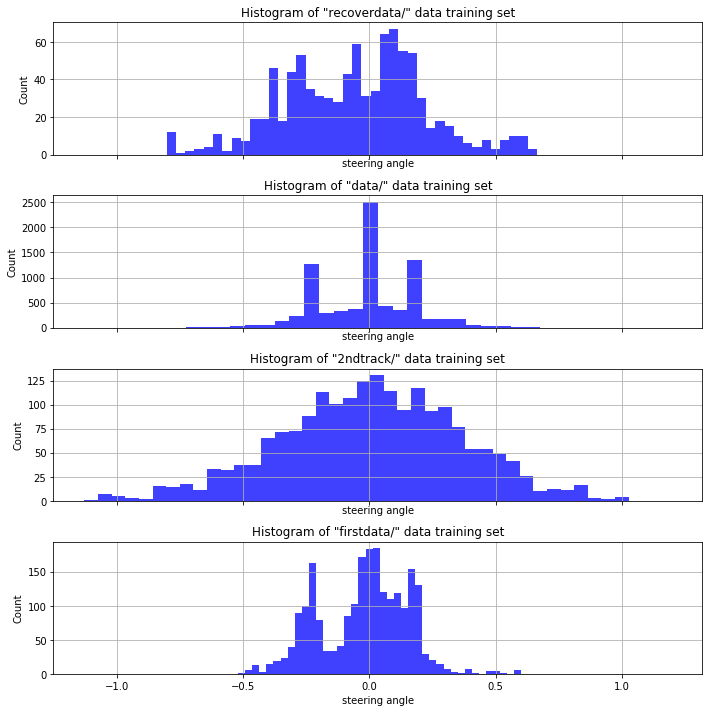

In [44]:
#Histogram of potential input data sets
prefixlist = ['recoverdata','data', '2ndtrack', 'firstdata']
fig,arr = plt.subplots(len(prefixlist), figsize=(10, 10), sharex=True)

for i, prefix in enumerate(prefixlist):
    images = []
    measurements = []
    print("processing data set: ", prefix)
    lines = []
    lines = read_driving_log(lines, prefix)
    lines = load_images_adjust_lrc_flip(lines, prefix)
    y_train = np.array(measurements)
    arr[i].hist(y_train, 40, facecolor='b', alpha=0.75)
    arr[i].set_xlabel('steering angle')
    arr[i].set_ylabel('Count')
    arr[i].set_title('Histogram of "' + prefix + '/" data training set')
    arr[i].grid(True)

fig.tight_layout()
plt.show()

